In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
gdf = gpd.read_file('/home/vollrath/Indonesia_sm/gdf_s1_aux.gpkg')
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')

station_trusted = [
    'BRG_621103_05',
    'BRG_621103_04',
    'BRG_621103_01',
    'BRG_621103_02',
    'BRG_621103_06',
    'BRG_621103_03'
]

stat_high = stations.stasiun[(stations['corr_gwl'] >= 0.5)]
stat_med = stations.stasiun[(stations['corr_gwl'] < 0.5) & (stations['corr_gwl'] >= 0.3)]
stat_low = stations.stasiun[(stations['corr_gwl'] < 0.3)]

In [49]:
d = {}
for i, station in enumerate(gdf.station.unique()):

    #print(station)
    
    # create a df for training without the station
    gdf_train = gdf[gdf.station != station]
    
    # create a df for test of the station
    gdf_test = gdf[gdf.station == station]
    #print(len(gdf), len(gdf_train), len(gdf_test))
    
    st = stations[stations.stasiun == station]
    #print(gdf_test.VV_stdDev.median(), st.corr_sm.values)
    
    
    d[station] = gdf_test.kVV_stdDev.median(), st.corr_sm.values[0]

In [50]:
stat = pd.DataFrame.from_dict(d, orient='index')
stat.columns

RangeIndex(start=0, stop=2, step=1)

Index(['sd', 'corr'], dtype='object')


<AxesSubplot:xlabel='sd', ylabel='corr'>

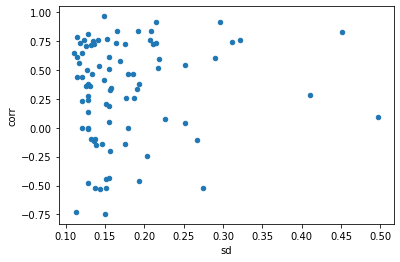

In [51]:
stat.columns = ['sd', 'corr']
print(stat.columns)
stat.plot(kind='scatter', x='sd', y='corr')

In [ ]:
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')

 
len(stat_high)

In [ ]:
bandlist = [
     #'orbit_direction',
     'VV', 'VH', 'VVVH_ratio', 'angle', 'LIA', #'layover', 'shadow', 'no_data_mask', 
     'precipitation', 'prec_3', 'prec_7', 'prec_30', 
     #'gldas_mean', 'gldas_stddev',
     'sm_1',  'sm_3', 'sm_7', 'sm_30',
     'elevation', 'aspect', 'slope', 
     'landcover',
     'kVV_mean', 'kVV_stdDev', 
     'kVV_p5', 'kVV_p95',
     'kVH_mean', 'kVH_stdDev', 
     'kVH_p5', 'kVH_p95', 
     'VV_mean', 'VV_stdDev', 
     'VV_p5', 'VV_p95', 
     'VH_mean', 'VH_stdDev', 
     'VH_p5', 'VH_p95'
    ]

#X = gdf_high[bandlist]
#y = gdf_high['SM_rata']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
gdf_high = gdf[gdf.station.isin(stat_high)].copy()

for i, station in enumerate(gdf_high.station.unique()):

    # create a df for training without the station
    gdf_train = gdf_high[gdf_high.station != station]
    
    # create a df for test of the station
    gdf_test = gdf_high[gdf_high.station == station]
    print(len(gdf_high), len(gdf_train), len(gdf_test))
    
    X_train, X_test = gdf_train[bandlist], gdf_test[bandlist]
    y_train, y_test = gdf_train['GWL_rata'], gdf_test['GWL_rata']
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse')
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    y_pred_train = regr.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print(station, r2_train, r2_test, mse_train, mse_test, y_train.max(), y_train.min(), y_test.mean(), y_test.std())
    d = {}
    d[station] = [len(gdf_train), len(gdf_test), r2_train, r2_test, mse_train, mse_test, y_test.mean(), y_test.std()]
    if i == 0:
        df = pd.DataFrame.from_dict(d, orient='index')
    else: 
        df = pd.concat([df, pd.DataFrame.from_dict(d, orient='index')])
        

In [ ]:
df.columns = ['samples_train', 'samples_test', 'r2train', 'r2test', 'rmse2train', 'rmse2test', 'test_mean_sm', 'test_sd_sm']
df = df.sort_values('r2test', ascending=False)

In [ ]:
df

In [ ]:
from pandas.plotting import table
from matplotlib import pylab as plt

In [ ]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df)  # where df is your data frame

plt.savefig('mytable.png')

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,20)) 
sns.heatmap(df, annot=True)

In [ ]:
df